
# Forced Alignment with Wav2Vec2

**Author**: [Moto Hira](moto@meta.com)_

This tutorial shows how to align transcript to speech with
``torchaudio``, using CTC segmentation algorithm described in
[CTC-Segmentation of Large Corpora for German End-to-end Speech
Recognition](https://arxiv.org/abs/2007.09127)_.

<div class="alert alert-info"><h4>Note</h4><p>This tutorial was originally written to illustrate a usecase
   for Wav2Vec2 pretrained model.

   TorchAudio now has a set of APIs designed for forced alignment.
   The [CTC forced alignment API tutorial](./ctc_forced_alignment_api_tutorial.html)_ illustrates the
   usage of :py:func:`torchaudio.functional.forced_align`, which is
   the core API.

   If you are looking to align your corpus, we recommend to use
   :py:class:`torchaudio.pipelines.Wav2Vec2FABundle`, which combines
   :py:func:`~torchaudio.functional.forced_align` and other support
   functions with pre-trained model specifically trained for
   forced-alignment. Please refer to the
   [Forced alignment for multilingual data](forced_alignment_for_multilingual_data_tutorial.html)_ which
   illustrates its usage.</p></div>


In [ ]:
from google.colab import drive
from google.colab import output
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!cp /content/drive/MyDrive/kasa_aahe_tu.wav .

cp: cannot stat '/content/drive/MyDrive/kasa_aahe_tu.wav': No such file or directory


In [ ]:
!pip install fairseq

In [ ]:
import torch

# Load the model
model = torch.load('/content/drive/MyDrive/SPRING_INX_wav2vec2_Marathi.pt')

# Print the model
print(model)

{'args': None, 'cfg': {'_name': None, 'common': {'_name': None, 'no_progress_bar': False, 'log_interval': 200, 'log_format': 'json', 'log_file': None, 'aim_repo': None, 'aim_run_hash': None, 'tensorboard_logdir': None, 'wandb_project': None, 'azureml_logging': False, 'seed': 1, 'cpu': False, 'tpu': False, 'bf16': False, 'memory_efficient_bf16': False, 'fp16': True, 'memory_efficient_fp16': False, 'fp16_no_flatten_grads': False, 'fp16_init_scale': 128, 'fp16_scale_window': None, 'fp16_scale_tolerance': 0.0, 'on_cpu_convert_precision': False, 'min_loss_scale': 0.0001, 'threshold_loss_scale': None, 'amp': False, 'amp_batch_retries': 2, 'amp_init_scale': 128, 'amp_scale_window': None, 'user_dir': None, 'empty_cache_freq': 0, 'all_gather_list_size': 16384, 'model_parallel_size': 1, 'quantization_config_path': None, 'profile': False, 'reset_logging': False, 'suppress_crashes': False, 'use_plasma_view': False, 'plasma_path': '/tmp/plasma'}, 'common_eval': {'_name': None, 'path': None, 'post_p

In [ ]:
from IPython.display import Javascript
from google.colab import output
from base64 import b64decode
from io import BytesIO
!pip -q install pydub
from pydub import AudioSegment
from matplotlib import pyplot as plt
import numpy as np
import scipy.io.wavfile
import io
import os
from IPython.display import Audio

RECORD = """
const sleep  = time => new Promise(resolve => setTimeout(resolve, time))
const b2text = blob => new Promise(resolve => {
  const reader = new FileReader()
  reader.onloadend = e => resolve(e.srcElement.result)
  reader.readAsDataURL(blob)
})
var record = time => new Promise(async resolve => {
  stream = await navigator.mediaDevices.getUserMedia({ audio: true })
  recorder = new MediaRecorder(stream)
  chunks = []
  recorder.ondataavailable = e => chunks.push(e.data)
  recorder.start()
  await sleep(time)
  recorder.onstop = async ()=>{
    blob = new Blob(chunks)
    text = await b2text(blob)
    resolve(text)
  }
  recorder.stop()
})
"""

def record(sec=4):
  display(Javascript(RECORD))
  s = output.eval_js('record(%d)' % (sec*1000))
  b = b64decode(s.split(',')[1])
  audio = AudioSegment.from_file(BytesIO(b))
  return audio



# Please comment below line, if you already uploaded the sound_path in '/content/'
# !rm recording.wav
#### You can run this module in the loop to record more repetitions of the digits.
sound_path = "kasa_aahe_tu.wav"
if os.path.isfile(sound_path):
    print("wavefile exists, later part of the code uses sound_path as input speech")
else:
    print("Recording the digits")
    wav = record(4.0) #It will record three seconds of your speech. You can change the duration.
    wav = wav.set_frame_rate(16000)
    sig=wav.get_array_of_samples()
    samples=np.array(sig).T.astype(np.float32)
    fp_arr = np.array(samples).T.astype(np.float32)
    fp_arr /= np.iinfo(sig.typecode).max
    scipy.io.wavfile.write(sound_path, 16000, fp_arr) #Please change the name.

wn = Audio(sound_path, autoplay=True)
display(wn)

wavefile exists, later part of the code uses sound_path as input speech


In [ ]:
!apt-get update
!apt-get install sox

In [ ]:
!apt-get install -y libsox-fmt-all libsox-dev sox > /dev/null

In [ ]:
import sys
import torch
import fairseq
import soundfile
import torch.nn.functional as F
import torchaudio.sox_effects as ta_sox
from IPython.display import display, Markdown
import torchaudio

model_path = '/content/drive/MyDrive/SPRING_INX_wav2vec2_Marathi.pt'
audio_path = "kasa_aahe_tu.wav"

# Ensure paths are correct and not directories
assert os.path.isfile(model_path), f"Model path is incorrect: {model_path}"
assert os.path.isfile(audio_path), f"Audio path is incorrect: {audio_path}"

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load and process the audio
audio, rate = torchaudio.load(audio_path)
effects = [["gain", "-n"]]
input_sample, rate = ta_sox.apply_effects_tensor(audio, rate, effects)
input_sample = input_sample.float().to(device)

# Normalize the input sample
with torch.no_grad():
    input_sample = F.layer_norm(input_sample, input_sample.shape)

# Load the model
model, cfg, task = fairseq.checkpoint_utils.load_model_ensemble_and_task([model_path])

print(type(cfg))
print(cfg)

# Prepare the model
model = model[0]
model.to(device)
model.eval()

# Get the dictionary and logits
token = task.target_dictionary
logits = model(source=input_sample, padding_mask=None)["encoder_out"]

# Compute emissions
emissions = torch.log_softmax(logits, dim=-1)
print(emissions.shape)
emission = emissions[:, 0, :].cpu().detach()
print(emission.shape)

# Get predicted ids
predicted_ids = torch.argmax(logits[:, 0], axis=-1)
predicted_ids = torch.unique_consecutive(predicted_ids).tolist()

# Convert predicted ids to transcription
transcription = token.string(predicted_ids)
t1 = transcription
t1 = transcription.replace(' ', '')
t1 = '|' + t1
if '.' in t1:
	t1 = t1.replace('.', '')

print(t1)
print(type(transcription))
# Clean transcription for display
transcription = transcription.replace(' ', '').replace('|', ' ').strip()
print(transcription)

# Display the transcription
display(Markdown(f'**{transcription}**'))

In [ ]:
print(type(token))
print(token)
type(predicted_ids)
print(predicted_ids)#These are the integer indices output by the model after processing the input
#audio. They represent the most likely sequence of tokens predicted by the model for the given input.
print(token.string(predicted_ids))
type(task)

<class 'fairseq.data.dictionary.Dictionary'>
[0, 18, 0, 9, 0, 10, 0, 42, 0, 30, 0, 4, 46, 0, 54, 0, 30, 0, 4, 24, 0, 20, 0, 23, 7, 8, 9, 0, 45, 0, 30, 0, 4, 33, 0, 10, 0, 46, 0, 27, 0, 30, 0, 4, 47, 0, 20, 0, 55, 0, 5, 0, 9, 0, 5, 0, 32, 4]
म ा ं झ र | द ू र | ग े ल ् य ा व र | अ ं द ि र | ख े ळ त ा त . |


fairseq.tasks.audio_finetuning.AudioFinetuningTask

In [ ]:
print(task.target_dictionary.symbols)

type(task.target_dictionary.symbols)
my_dict = task.target_dictionary
print(len(my_dict))
for tokens,indices in enumerate(my_dict.symbols):
  print(tokens, " ", indices)
print(type(token.symbols))
# for symbols,integers in enumerate(token.symbols):
#   print(f"{symbols} --> {integers}")

['<s>', '<pad>', '</s>', '<unk>', '|', 'त', 'ो', '्', 'य', 'ा', 'ं', 'च', 'श', 'ी', '1', '9', '4', '5', 'म', 'ध', 'े', 'ज', 'ड', 'ल', 'ग', 'आ', 'ण', 'ि', '8', 'प', 'र', 'ह', '.', 'अ', 'ॅ', 'स', 'ट', 'न', 'फ', 'ँ', 'क', 'ु', 'झ', ',', 'ब', 'व', 'द', 'ख', 'ष', 'थ', 'ए', 'ई', 'घ', 'ऊ', 'ू', 'ळ', 'उ', 'इ', 'ः', 'ठ', 'h', 'n', 'ृ', 'छ', 'भ', 'ै', 'ढ', 'ॉ', '४', '६', '२', '१', '७', '५', '९', '०', '?', 'ञ', 'w', 'i', 'f', 'p', 'c', 'ओ', '८', '2', '0', '7', '३', 'ौ', 'g', 's', 'ऐ', 'a', 'l', 'm', 'z', '3', 'औ', 'ऑ', 'o', 't', 'b', '6', 'x', 'e', 'y', 'u', 'q', 'v', 'r', 'k', 'd', '-', '°', 'ऋ', 'j', '²', 'ऍ', '!', ':', 'ङ', 'ॐ', '।', 'X', 'T', 'V', 'Y', 'O', 'S', 'H', 'A', 'P', 'M', 'C', 'F', 'I', 'B', 'E', 'D', 'J', 'W', 'L', 'K', 'R', 'G', 'N', 'Z', 'U', 'Q']
150
0   <s>
1   <pad>
2   </s>
3   <unk>
4   |
5   त
6   ो
7   ्
8   य
9   ा
10   ं
11   च
12   श
13   ी
14   1
15   9
16   4
17   5
18   म
19   ध
20   े
21   ज
22   ड
23   ल
24   ग
25   आ
26   ण
27   ि
28   8
29   प
30   र
31   ह
32   

['<s>', '<pad>', '</s>', '<unk>', '|', 'त', 'ो', '्', 'य', 'ा', 'ं', 'च', 'श', 'ी', '1', '9', '4', '5', 'म', 'ध', 'े', 'ज', 'ड', 'ल', 'ग', 'आ', 'ण', 'ि', '8', 'प', 'र', 'ह', '.', 'अ', 'ॅ', 'स', 'ट', 'न', 'फ', 'ँ', 'क', 'ु', 'झ', ',', 'ब', 'व', 'द', 'ख', 'ष', 'थ', 'ए', 'ई', 'घ', 'ऊ', 'ू', 'ळ', 'उ', 'इ', 'ः', 'ठ', 'h', 'n', 'ृ', 'छ', 'भ', 'ै', 'ढ', 'ॉ', '४', '६', '२', '१', '७', '५', '९', '०', '?', 'ञ', 'w', 'i', 'f', 'p', 'c', 'ओ', '८', '2', '0', '7', '३', 'ौ', 'g', 's', 'ऐ', 'a', 'l', 'm', 'z', '3', 'औ', 'ऑ', 'o', 't', 'b', '6', 'x', 'e', 'y', 'u', 'q', 'v', 'r', 'k', 'd', '-', '°', 'ऋ', 'j', '²', 'ऍ', '!', ':', 'ङ', 'ॐ', '।', 'X', 'T', 'V', 'Y', 'O', 'S', 'H', 'A', 'P', 'M', 'C', 'F', 'I', 'B', 'E', 'D', 'J', 'W', 'L', 'K', 'R', 'G', 'N', 'Z', 'U', 'Q']


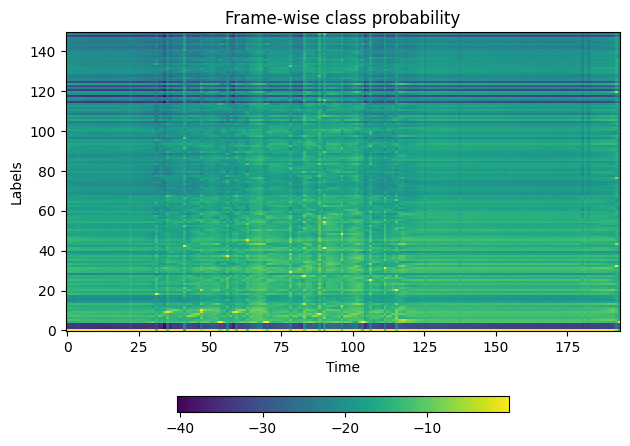

In [ ]:
# print(token.string(predicted_ids))

symbols = token.symbols
print(symbols)

import matplotlib.pyplot as plt

def plot(emission):
    fig, ax = plt.subplots()
    emission_cpu = emission.cpu().detach()  # Detach the tensor from its computation graph

    # Plot the emission matrix directly
    img = ax.imshow(emission_cpu.T, aspect='auto', origin='lower', interpolation='none')

    ax.set_title("Frame-wise class probability")
    ax.set_xlabel("Time")
    ax.set_ylabel("Labels")
    fig.colorbar(img, ax=ax, shrink=0.6, location="bottom")
    fig.tight_layout()
    plt.show()

# Assuming emission is already defined and has shape [seq_length, num_classes]
plot(emission)

In [ ]:
import torch

# We enclose the transcript with space tokens, which represent SOS and EOS.
transcript = t1
#ye hamesha nahi likha hai

#write a code to automatically write the transcript(use a loop)
labels = list(set(transcript))  # Get unique characters from the transcript
labels.sort()  # Optional: sort the labels

dictionary = {c: i for i, c in enumerate(labels)}

tokens = [dictionary[c] for c in transcript]
print(list(zip(transcript, tokens)))


def get_trellis(emission, tokens, blank_id=0):
    num_frame = emission.size(0)
    num_tokens = len(tokens)

    trellis = torch.zeros((num_frame, num_tokens))

    # Ensure blank_id is a scalar
    if torch.is_tensor(blank_id):
        blank_id = blank_id.item()

    cumsum = torch.cumsum(emission[1:,blank_id],dim=0)
    trellis[1:,0] = cumsum
    # trellis[1:, 0] = torch.cumsum(emission[1:, blank_id], 0).unsqueeze(1)
    # print(torch.cumsum(emission[1:, blank_id], 0).shape)
    trellis[0, 1:] = -float("inf")
    trellis[-num_tokens + 1 :, 0] = float("inf")
    for t in range(num_frame - 1):
        trellis[t + 1, 1:] = torch.maximum(
            # Score for staying at the same token
            trellis[t, 1:] + emission[t, blank_id],
            # Score for changing to the next token
            trellis[t, :-1] + emission[t, tokens[1:]],
        )
    return trellis


trellis = get_trellis(emission, tokens)

print(trellis)
print(emission)
#150 kya hai  yaha??
#in depth understanding of trellis and emmissiom

print(len(tokens))
print(labels)
print(emission.shape)
print(trellis.shape)
print(type(emission))
print(type(trellis))

[('|', 0), ('म', 6), ('ा', 11), ('झ', 3), ('ं', 1), ('|', 0), ('न', 4), ('ा', 11), ('व', 8), ('|', 0), ('प', 5), ('ि', 12), ('य', 7), ('ु', 13), ('ष', 9), ('|', 0), ('आ', 2), ('ह', 10), ('े', 14), ('|', 0)]
tensor([[ 0.0000e+00,        -inf,        -inf,  ...,        -inf,
                -inf,        -inf],
        [-6.7828e-05, -1.4421e+01,        -inf,  ...,        -inf,
                -inf,        -inf],
        [-1.2326e-04, -1.4421e+01, -2.8021e+01,  ...,        -inf,
                -inf,        -inf],
        ...,
        [        inf,         inf,         inf,  ..., -2.1722e+02,
         -2.3267e+02, -2.3267e+02],
        [        inf,         inf,         inf,  ...,         inf,
         -2.3267e+02, -2.3267e+02],
        [        inf,         inf,         inf,  ...,         inf,
                 inf, -2.3824e+02]])
tensor([[-8.5946e-05, -3.3884e+01, -3.3476e+01,  ..., -3.1814e+01,
         -2.1916e+01, -3.1067e+01],
        [-6.7828e-05, -3.4441e+01, -3.4002e+01,  ..., -3.2

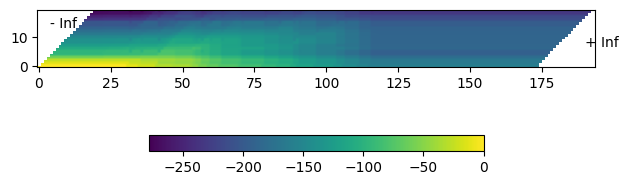

In [ ]:
def plot():
    fig, ax = plt.subplots()
    img = ax.imshow(trellis.T, origin="lower")
    ax.annotate("- Inf", (trellis.size(1) / 5, trellis.size(1) / 1.5))
    ax.annotate("+ Inf", (trellis.size(0) - trellis.size(1) / 5, trellis.size(1) / 3))
    fig.colorbar(img, ax=ax, shrink=0.6, location="bottom")
    fig.tight_layout()


plot()

In [ ]:
from dataclasses import dataclass

@dataclass
class Point:
    token_index: int
    time_index: int
    score: float


def backtrack(trellis, emission, tokens, blank_id=0):
    t, j = trellis.size(0) - 1, trellis.size(1) - 1

    path = [Point(j, t, emission[t, blank_id].exp().item())]
    while j > 0:
        # Should not happen but just in case
        assert t > 0

        # 1. Figure out if the current position was stay or change
        # Frame-wise score of stay vs change
        p_stay = emission[t - 1, blank_id]
        p_change = emission[t - 1, tokens[j]]

        # Context-aware score for stay vs change
        stayed = trellis[t - 1, j] + p_stay
        changed = trellis[t - 1, j - 1] + p_change

        # Update position
        t -= 1
        if changed > stayed:
            j -= 1

        # Store the path with frame-wise probability.
        prob = (p_change if changed > stayed else p_stay).exp().item()
        path.append(Point(j, t, prob))

    # Now j == 0, which means, it reached the SoS.
    # Fill up the rest for the sake of visualization
    while t > 0:
        prob = emission[t - 1, blank_id].exp().item()
        path.append(Point(j, t - 1, prob))
        t -= 1

    return path[::-1]


path = backtrack(trellis, emission, tokens)
for p in path:
    print(p)

  #score kya hai yaha..

Point(token_index=0, time_index=0, score=0.9999140501022339)
Point(token_index=0, time_index=1, score=0.9999321699142456)
Point(token_index=0, time_index=2, score=0.9999445676803589)
Point(token_index=0, time_index=3, score=1.5914858977339463e-06)
Point(token_index=1, time_index=4, score=0.999945878982544)
Point(token_index=1, time_index=5, score=0.9999568462371826)
Point(token_index=1, time_index=6, score=0.9999611377716064)
Point(token_index=1, time_index=7, score=0.9999603033065796)
Point(token_index=1, time_index=8, score=0.9999631643295288)
Point(token_index=1, time_index=9, score=0.9999632835388184)
Point(token_index=1, time_index=10, score=0.9999657869338989)
Point(token_index=1, time_index=11, score=0.9999628067016602)
Point(token_index=1, time_index=12, score=0.9999643564224243)
Point(token_index=1, time_index=13, score=0.9999657869338989)
Point(token_index=1, time_index=14, score=0.9999641180038452)
Point(token_index=1, time_index=15, score=0.999966025352478)
Point(token_inde

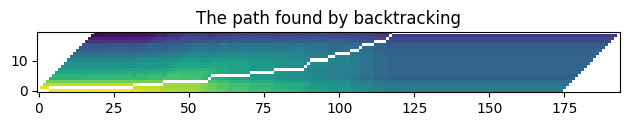

In [ ]:
def plot_trellis_with_path(trellis, path):
    # To plot trellis with path, we take advantage of 'nan' value
    trellis_with_path = trellis.clone()
    for _, p in enumerate(path):
        trellis_with_path[p.time_index, p.token_index] = float("nan")
    plt.imshow(trellis_with_path.T, origin="lower")
    plt.title("The path found by backtracking")
    plt.tight_layout()


plot_trellis_with_path(trellis, path)
#not cummulative..we re just proceeding to the next label

In [ ]:
@dataclass
class Segment:
    label: str
    start: int
    end: int
    score: float

    def _repr_(self):
        return f"{self.label}\t({self.score:4.2f}): [{self.start:5d}, {self.end:5d})"

    @property
    def length(self):
        return self.end - self.start


def merge_repeats(path):
    i1, i2 = 0, 0
    segments = []
    while i1 < len(path):
        while i2 < len(path) and path[i1].token_index == path[i2].token_index:
            i2 += 1
        score = sum(path[k].score for k in range(i1, i2)) / (i2 - i1)
        segments.append(
            Segment(
                transcript[path[i1].token_index],
                path[i1].time_index,
                path[i2 - 1].time_index + 1,
                score,
            )
        )
        i1 = i2
    return segments


segments = merge_repeats(path)
for seg in segments:
    print(seg)

Segment(label='|', start=0, end=4, score=0.749948094795684)
Segment(label='म', start=4, end=32, score=0.9642424262657171)
Segment(label='ा', start=32, end=42, score=0.7981939117305326)
Segment(label='झ', start=42, end=57, score=0.7350151026315331)
Segment(label='ं', start=57, end=58, score=0.9999468326568604)
Segment(label='|', start=58, end=71, score=0.7761602404565425)
Segment(label='न', start=71, end=79, score=0.8748044445579808)
Segment(label='ा', start=79, end=89, score=0.8985382637009025)
Segment(label='व', start=89, end=90, score=0.9997861981391907)
Segment(label='|', start=90, end=91, score=1.224946117872605e-06)
Segment(label='प', start=91, end=97, score=0.8344480089532832)
Segment(label='ि', start=97, end=99, score=0.5000305745343212)
Segment(label='य', start=99, end=104, score=0.7986939285881818)
Segment(label='ु', start=104, end=107, score=0.5457686494410154)
Segment(label='ष', start=107, end=108, score=0.9998382329940796)
Segment(label='|', start=108, end=112, score=0.7498

<ipython-input-44-bec29a247475>:38: UserWarning: Glyph 2350 (\N{DEVANAGARI LETTER MA}) missing from current font.
  fig.tight_layout()
<ipython-input-44-bec29a247475>:38: UserWarning: Matplotlib currently does not support Devanagari natively.
  fig.tight_layout()
<ipython-input-44-bec29a247475>:38: UserWarning: Glyph 2366 (\N{DEVANAGARI VOWEL SIGN AA}) missing from current font.
  fig.tight_layout()
<ipython-input-44-bec29a247475>:38: UserWarning: Glyph 2333 (\N{DEVANAGARI LETTER JHA}) missing from current font.
  fig.tight_layout()
<ipython-input-44-bec29a247475>:38: UserWarning: Glyph 2306 (\N{DEVANAGARI SIGN ANUSVARA}) missing from current font.
  fig.tight_layout()
<ipython-input-44-bec29a247475>:38: UserWarning: Glyph 2344 (\N{DEVANAGARI LETTER NA}) missing from current font.
  fig.tight_layout()
<ipython-input-44-bec29a247475>:38: UserWarning: Glyph 2357 (\N{DEVANAGARI LETTER VA}) missing from current font.
  fig.tight_layout()
<ipython-input-44-bec29a247475>:38: UserWarning: Gly

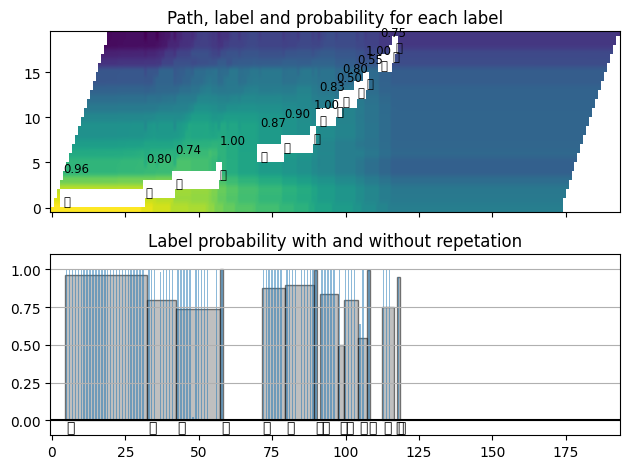

In [ ]:
def plot_trellis_with_segments(trellis, segments, transcript):
    # To plot trellis with path, we take advantage of 'nan' value
    trellis_with_path = trellis.clone()
    for i, seg in enumerate(segments):
        if seg.label != "|":
            trellis_with_path[seg.start : seg.end, i] = float("nan")

    fig, [ax1, ax2] = plt.subplots(2, 1, sharex=True)
    ax1.set_title("Path, label and probability for each label")
    ax1.imshow(trellis_with_path.T, origin="lower", aspect="auto")

    for i, seg in enumerate(segments):
        if seg.label != "|":
            ax1.annotate(seg.label, (seg.start, i - 0.7), size="small")
            ax1.annotate(f"{seg.score:.2f}", (seg.start, i + 3), size="small")

    ax2.set_title("Label probability with and without repetation")
    xs, hs, ws = [], [], []
    for seg in segments:
        if seg.label != "|":
            xs.append((seg.end + seg.start) / 2 + 0.4)
            hs.append(seg.score)
            ws.append(seg.end - seg.start)
            ax2.annotate(seg.label, (seg.start + 0.8, -0.07))
    ax2.bar(xs, hs, width=ws, color="gray", alpha=0.5, edgecolor="black")

    xs, hs = [], []
    for p in path:
        label = transcript[p.token_index]
        if label != "|":
            xs.append(p.time_index + 1)
            hs.append(p.score)

    ax2.bar(xs, hs, width=0.5, alpha=0.5)
    ax2.axhline(0, color="black")
    ax2.grid(True, axis="y")
    ax2.set_ylim(-0.1, 1.1)
    fig.tight_layout()


plot_trellis_with_segments(trellis, segments, transcript)

In [ ]:
# Merge words
def merge_words(segments, separator="|"):
    words = []
    i1, i2 = 0, 0
    while i1 < len(segments):
        if i2 >= len(segments) or segments[i2].label == separator:
            if i1 != i2:
                segs = segments[i1:i2]
                word = "".join([seg.label for seg in segs])
                score = sum(seg.score * seg.length for seg in segs) / sum(seg.length for seg in segs)
                words.append(Segment(word, segments[i1].start, segments[i2 - 1].end, score))
            i1 = i2 + 1
            i2 = i1
        else:
            i2 += 1
    return words


word_segments = merge_words(segments)
for word in word_segments:
    print(word)

Segment(label='माझं', start=4, end=58, score=0.87047963749769)
Segment(label='नाव', start=71, end=90, score=0.8938739153480032)
Segment(label='पियुष', start=91, end=108, score=0.7433742957086104)
Segment(label='आहे', start=112, end=118, score=0.6586408750562995)


<ipython-input-55-f67bb74b2554>:41: UserWarning: Glyph 2325 (\N{DEVANAGARI LETTER KA}) missing from current font.
  fig.tight_layout()
<ipython-input-55-f67bb74b2554>:41: UserWarning: Matplotlib currently does not support Devanagari natively.
  fig.tight_layout()
<ipython-input-55-f67bb74b2554>:41: UserWarning: Glyph 2360 (\N{DEVANAGARI LETTER SA}) missing from current font.
  fig.tight_layout()
<ipython-input-55-f67bb74b2554>:41: UserWarning: Glyph 2366 (\N{DEVANAGARI VOWEL SIGN AA}) missing from current font.
  fig.tight_layout()
<ipython-input-55-f67bb74b2554>:41: UserWarning: Glyph 2310 (\N{DEVANAGARI LETTER AA}) missing from current font.
  fig.tight_layout()
<ipython-input-55-f67bb74b2554>:41: UserWarning: Glyph 2361 (\N{DEVANAGARI LETTER HA}) missing from current font.
  fig.tight_layout()
<ipython-input-55-f67bb74b2554>:41: UserWarning: Glyph 2375 (\N{DEVANAGARI VOWEL SIGN E}) missing from current font.
  fig.tight_layout()
<ipython-input-55-f67bb74b2554>:41: UserWarning: Glyph

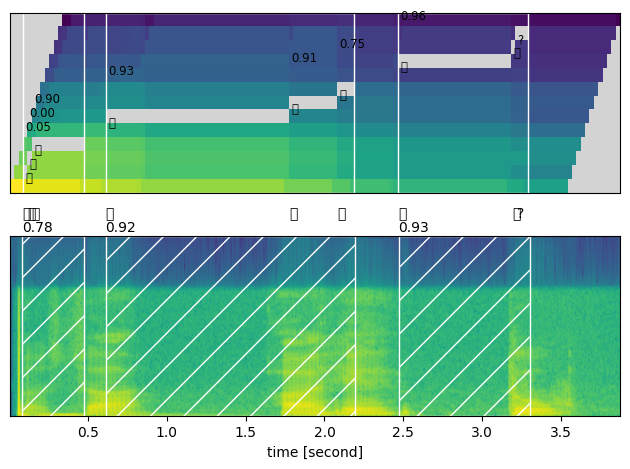

In [ ]:
import librosa

# Load the audio file
waveform, sample_rate = librosa.load(audio_path)

def plot_alignments(trellis, segments, word_segments, waveform, sample_rate=16000):
    trellis_with_path = trellis.clone()
    for i, seg in enumerate(segments):
        if seg.label != "|":
            trellis_with_path[seg.start : seg.end, i] = float("nan")

    fig, [ax1, ax2] = plt.subplots(2, 1)

    ax1.imshow(trellis_with_path.T, origin="lower", aspect="auto")
    ax1.set_facecolor("lightgray")
    ax1.set_xticks([])
    ax1.set_yticks([])

    for word in word_segments:
        ax1.axvspan(word.start - 0.5, word.end - 0.5, edgecolor="white", facecolor="none")

    for i, seg in enumerate(segments):
        if seg.label != "|":
            ax1.annotate(seg.label, (seg.start, i - 0.7), size="small")
            ax1.annotate(f"{seg.score:.2f}", (seg.start, i + 3), size="small")

    # The original waveform
    ratio = len(waveform) / sample_rate / trellis.size(0)
    ax2.specgram(waveform, Fs=sample_rate)
    for word in word_segments:
        x0 = ratio * word.start
        x1 = ratio * word.end
        ax2.axvspan(x0, x1, facecolor="none", edgecolor="white", hatch="/")
        ax2.annotate(f"{word.score:.2f}", (x0, sample_rate * 0.51), annotation_clip=False)

    for seg in segments:
        if seg.label != "|":
            ax2.annotate(seg.label, (seg.start * ratio, sample_rate * 0.55), annotation_clip=False)
    ax2.set_xlabel("time [second]")
    ax2.set_yticks([])
    fig.tight_layout()

    #karu me bohot jaldi boldiya..isliye 'r' ka confidence score kam aaya
plot_alignments(trellis, segments, word_segments, waveform)

In [ ]:
sample_rate = 16000
def display_segment(i):
    ratio = len(waveform) / trellis.size(0)
    word = word_segments[i]
    x0 = int(ratio * word.start)
    x1 = int(ratio * word.end)
    print(f"{word.label} ({word.score:.2f}): {x0 / sample_rate:.3f} - {x1 / sample_rate:.3f} sec")
    segment = waveform[x0:x1]
    return IPython.display.Audio(segment, rate=sample_rate)

In [ ]:
import IPython
# Generate the audio for each segment
print(transcript)
IPython.display.Audio(audio_path)

|कसा|आहे|तू?|


In [ ]:
display_segment(0)

कसा (0.78): 0.083 - 0.472 sec


In [ ]:
display_segment(1)

आहे (0.92): 0.611 - 2.193 sec


In [ ]:
display_segment(2)

तू? (0.93): 2.471 - 3.303 sec


In [ ]:
display_segment(3)

आहे (0.66): 3.103 - 3.269 sec


In [ ]:
display_segment(4)

खेळतात (0.65): 2.139 - 2.751 sec


In [ ]:
display_segment(5)

चांगल्े (0.65): 2.248 - 3.330 sec


In [ ]:
display_segment(6)

असतात (0.59): 3.469 - 3.802 sec


Point(token_index=0, time_index=0, score=1.9487181901931763)
Point(token_index=0, time_index=1, score=1.4762753248214722)
Point(token_index=0, time_index=2, score=0.6854990720748901)
Point(token_index=0, time_index=3, score=0.9284282922744751)
Point(token_index=0, time_index=4, score=6.469353199005127)
Point(token_index=0, time_index=5, score=0.4648330807685852)
Point(token_index=0, time_index=6, score=2.7450296878814697)
Point(token_index=0, time_index=7, score=5.9754815101623535)
Point(token_index=1, time_index=8, score=0.8636789917945862)
Point(token_index=1, time_index=9, score=1.4448699951171875)
Point(token_index=1, time_index=10, score=0.5698916912078857)
Point(token_index=1, time_index=11, score=3.1135380268096924)
Point(token_index=1, time_index=12, score=4.24599552154541)
Point(token_index=1, time_index=13, score=2.355006217956543)
Point(token_index=1, time_index=14, score=1.8658510446548462)
Point(token_index=1, time_index=15, score=0.5040091276168823)
Point(token_index=1, t

<ipython-input-32-5e9ce3f0d363>:149: UserWarning: Glyph 2368 (\N{DEVANAGARI VOWEL SIGN II}) missing from current font.
  fig.tight_layout()
<ipython-input-32-5e9ce3f0d363>:149: UserWarning: Matplotlib currently does not support Devanagari natively.
  fig.tight_layout()
<ipython-input-32-5e9ce3f0d363>:149: UserWarning: Glyph 2346 (\N{DEVANAGARI LETTER PA}) missing from current font.
  fig.tight_layout()
<ipython-input-32-5e9ce3f0d363>:149: UserWarning: Glyph 2367 (\N{DEVANAGARI VOWEL SIGN I}) missing from current font.
  fig.tight_layout()
<ipython-input-32-5e9ce3f0d363>:149: UserWarning: Glyph 2351 (\N{DEVANAGARI LETTER YA}) missing from current font.
  fig.tight_layout()
<ipython-input-32-5e9ce3f0d363>:149: UserWarning: Glyph 2369 (\N{DEVANAGARI VOWEL SIGN U}) missing from current font.
  fig.tight_layout()
<ipython-input-32-5e9ce3f0d363>:149: UserWarning: Glyph 2359 (\N{DEVANAGARI LETTER SSA}) missing from current font.
  fig.tight_layout()
<ipython-input-32-5e9ce3f0d363>:149: UserWa

Segment(label='मी', start=0, end=24, score=2.224366089950005)
Segment(label=' पियुष', start=25, end=91, score=2.7784493996789963)
Segment(label=' आहे', start=92, end=132, score=2.0154494319111107)


<ipython-input-32-5e9ce3f0d363>:216: UserWarning: Glyph 2368 (\N{DEVANAGARI VOWEL SIGN II}) missing from current font.
  fig.tight_layout()
<ipython-input-32-5e9ce3f0d363>:216: UserWarning: Matplotlib currently does not support Devanagari natively.
  fig.tight_layout()
<ipython-input-32-5e9ce3f0d363>:216: UserWarning: Glyph 2346 (\N{DEVANAGARI LETTER PA}) missing from current font.
  fig.tight_layout()
<ipython-input-32-5e9ce3f0d363>:216: UserWarning: Glyph 2367 (\N{DEVANAGARI VOWEL SIGN I}) missing from current font.
  fig.tight_layout()
<ipython-input-32-5e9ce3f0d363>:216: UserWarning: Glyph 2351 (\N{DEVANAGARI LETTER YA}) missing from current font.
  fig.tight_layout()
<ipython-input-32-5e9ce3f0d363>:216: UserWarning: Glyph 2369 (\N{DEVANAGARI VOWEL SIGN U}) missing from current font.
  fig.tight_layout()
<ipython-input-32-5e9ce3f0d363>:216: UserWarning: Glyph 2359 (\N{DEVANAGARI LETTER SSA}) missing from current font.
  fig.tight_layout()
<ipython-input-32-5e9ce3f0d363>:216: UserWa

मी| पियुष| आहे|
मी (2.22): 0.000 - 0.657 sec
 पियुष (2.78): 0.684 - 2.491 sec
 आहे (2.02): 2.518 - 3.613 sec


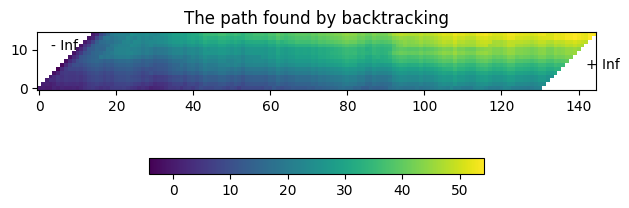

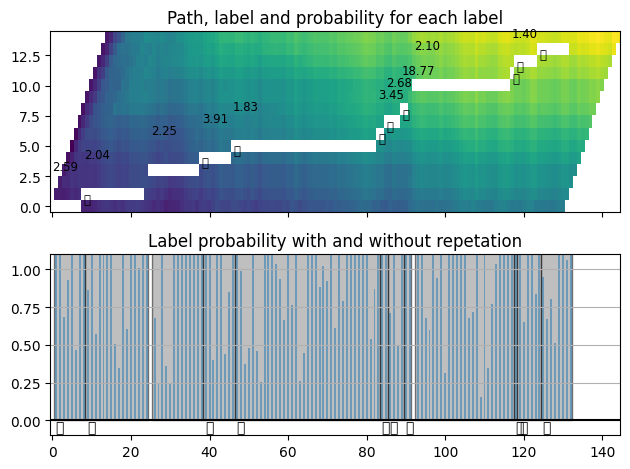

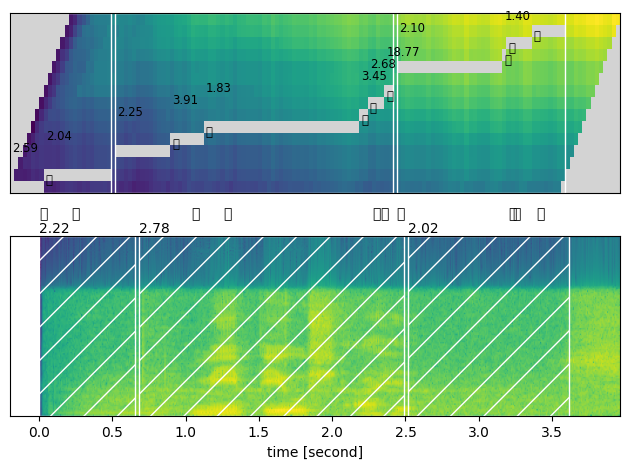

In [ ]:
def plot():
    fig, ax = plt.subplots()
    img = ax.imshow(trellis.T, origin="lower")
    ax.annotate("- Inf", (trellis.size(1) / 5, trellis.size(1) / 1.5))
    ax.annotate("+ Inf", (trellis.size(0) - trellis.size(1) / 5, trellis.size(1) / 3))
    fig.colorbar(img, ax=ax, shrink=0.6, location="bottom")
    fig.tight_layout()


plot()

from dataclasses import dataclass

@dataclass
class Point:
    token_index: int
    time_index: int
    score: float


def backtrack(trellis, emission, tokens, blank_id=0):
    t, j = trellis.size(0) - 1, trellis.size(1) - 1

    path = [Point(j, t, emission[t, blank_id].exp().item())]
    while j > 0:
        # Should not happen but just in case
        assert t > 0

        # 1. Figure out if the current position was stay or change
        # Frame-wise score of stay vs change
        p_stay = emission[t - 1, blank_id]
        p_change = emission[t - 1, tokens[j]]

        # Context-aware score for stay vs change
        stayed = trellis[t - 1, j] + p_stay
        changed = trellis[t - 1, j - 1] + p_change

        # Update position
        t -= 1
        if changed > stayed:
            j -= 1

        # Store the path with frame-wise probability.
        prob = (p_change if changed > stayed else p_stay).exp().item()
        path.append(Point(j, t, prob))

    # Now j == 0, which means, it reached the SoS.
    # Fill up the rest for the sake of visualization
    while t > 0:
        prob = emission[t - 1, blank_id].exp().item()
        path.append(Point(j, t - 1, prob))
        t -= 1

    return path[::-1]


path = backtrack(trellis, emission, tokens)
for p in path:
    print(p)

def plot_trellis_with_path(trellis, path):
    # To plot trellis with path, we take advantage of 'nan' value
    trellis_with_path = trellis.clone()
    for _, p in enumerate(path):
        trellis_with_path[p.time_index, p.token_index] = float("nan")
    plt.imshow(trellis_with_path.T, origin="lower")
    plt.title("The path found by backtracking")
    plt.tight_layout()


plot_trellis_with_path(trellis, path)

# Merge the labels
@dataclass
class Segment:
    label: str
    start: int
    end: int
    score: float

    def _repr_(self):
        return f"{self.label}\t({self.score:4.2f}): [{self.start:5d}, {self.end:5d})"

    @property
    def length(self):
        return self.end - self.start


def merge_repeats(path):
    i1, i2 = 0, 0
    segments = []
    while i1 < len(path):
        while i2 < len(path) and path[i1].token_index == path[i2].token_index:
            i2 += 1
        score = sum(path[k].score for k in range(i1, i2)) / (i2 - i1)
        segments.append(
            Segment(
                transcript[path[i1].token_index],
                path[i1].time_index,
                path[i2 - 1].time_index + 1,
                score,
            )
        )
        i1 = i2
    return segments


segments = merge_repeats(path)
for seg in segments:
    print(seg)

def plot_trellis_with_segments(trellis, segments, transcript):
    # To plot trellis with path, we take advantage of 'nan' value
    trellis_with_path = trellis.clone()
    for i, seg in enumerate(segments):
        if seg.label != "|":
            trellis_with_path[seg.start : seg.end, i] = float("nan")

    fig, [ax1, ax2] = plt.subplots(2, 1, sharex=True)
    ax1.set_title("Path, label and probability for each label")
    ax1.imshow(trellis_with_path.T, origin="lower", aspect="auto")

    for i, seg in enumerate(segments):
        if seg.label != "|":
            ax1.annotate(seg.label, (seg.start, i - 0.7), size="small")
            ax1.annotate(f"{seg.score:.2f}", (seg.start, i + 3), size="small")

    ax2.set_title("Label probability with and without repetation")
    xs, hs, ws = [], [], []
    for seg in segments:
        if seg.label != "|":
            xs.append((seg.end + seg.start) / 2 + 0.4)
            hs.append(seg.score)
            ws.append(seg.end - seg.start)
            ax2.annotate(seg.label, (seg.start + 0.8, -0.07))
    ax2.bar(xs, hs, width=ws, color="gray", alpha=0.5, edgecolor="black")

    xs, hs = [], []
    for p in path:
        label = transcript[p.token_index]
        if label != "|":
            xs.append(p.time_index + 1)
            hs.append(p.score)

    ax2.bar(xs, hs, width=0.5, alpha=0.5)
    ax2.axhline(0, color="black")
    ax2.grid(True, axis="y")
    ax2.set_ylim(-0.1, 1.1)
    fig.tight_layout()


plot_trellis_with_segments(trellis, segments, transcript)

# Merge words
def merge_words(segments, separator="|"):
    words = []
    i1, i2 = 0, 0
    while i1 < len(segments):
        if i2 >= len(segments) or segments[i2].label == separator:
            if i1 != i2:
                segs = segments[i1:i2]
                word = "".join([seg.label for seg in segs])
                score = sum(seg.score * seg.length for seg in segs) / sum(seg.length for seg in segs)
                words.append(Segment(word, segments[i1].start, segments[i2 - 1].end, score))
            i1 = i2 + 1
            i2 = i1
        else:
            i2 += 1
    return words


word_segments = merge_words(segments)
for word in word_segments:
    print(word)

import librosa

# Load the audio file
waveform, sample_rate = librosa.load('recording.wav')

def plot_alignments(trellis, segments, word_segments, waveform, sample_rate=16000):
    trellis_with_path = trellis.clone()
    for i, seg in enumerate(segments):
        if seg.label != "|":
            trellis_with_path[seg.start : seg.end, i] = float("nan")

    fig, [ax1, ax2] = plt.subplots(2, 1)

    ax1.imshow(trellis_with_path.T, origin="lower", aspect="auto")
    ax1.set_facecolor("lightgray")
    ax1.set_xticks([])
    ax1.set_yticks([])

    for word in word_segments:
        ax1.axvspan(word.start - 0.5, word.end - 0.5, edgecolor="white", facecolor="none")

    for i, seg in enumerate(segments):
        if seg.label != "|":
            ax1.annotate(seg.label, (seg.start, i - 0.7), size="small")
            ax1.annotate(f"{seg.score:.2f}", (seg.start, i + 3), size="small")

    # The original waveform
    ratio = len(waveform) / sample_rate / trellis.size(0)
    ax2.specgram(waveform, Fs=sample_rate)
    for word in word_segments:
        x0 = ratio * word.start
        x1 = ratio * word.end
        ax2.axvspan(x0, x1, facecolor="none", edgecolor="white", hatch="/")
        ax2.annotate(f"{word.score:.2f}", (x0, sample_rate * 0.51), annotation_clip=False)

    for seg in segments:
        if seg.label != "|":
            ax2.annotate(seg.label, (seg.start * ratio, sample_rate * 0.55), annotation_clip=False)
    ax2.set_xlabel("time [second]")
    ax2.set_yticks([])
    fig.tight_layout()


plot_alignments(trellis, segments, word_segments, waveform)

sample_rate = 16000
def display_segment(i):
    ratio = len(waveform) / trellis.size(0)
    word = word_segments[i]
    x0 = int(ratio * word.start)
    x1 = int(ratio * word.end)
    print(f"{word.label} ({word.score:.2f}): {x0 / sample_rate:.3f} - {x1 / sample_rate:.3f} sec")
    segment = waveform[x0:x1]
    return IPython.display.Audio(segment, rate=sample_rate)

import IPython
# Generate the audio for each segment
print(transcript)
IPython.display.Audio('recording.wav')

display_segment(0)

display_segment(1)

display_segment(2)

In [ ]:
marathi_labels = token.symbols

print("Marathi labels:", marathi_labels)

Marathi labels: ['<s>', '<pad>', '</s>', '<unk>', '|', 'त', 'ो', '्', 'य', 'ा', 'ं', 'च', 'श', 'ी', '1', '9', '4', '5', 'म', 'ध', 'े', 'ज', 'ड', 'ल', 'ग', 'आ', 'ण', 'ि', '8', 'प', 'र', 'ह', '.', 'अ', 'ॅ', 'स', 'ट', 'न', 'फ', 'ँ', 'क', 'ु', 'झ', ',', 'ब', 'व', 'द', 'ख', 'ष', 'थ', 'ए', 'ई', 'घ', 'ऊ', 'ू', 'ळ', 'उ', 'इ', 'ः', 'ठ', 'h', 'n', 'ृ', 'छ', 'भ', 'ै', 'ढ', 'ॉ', '४', '६', '२', '१', '७', '५', '९', '०', '?', 'ञ', 'w', 'i', 'f', 'p', 'c', 'ओ', '८', '2', '0', '7', '३', 'ौ', 'g', 's', 'ऐ', 'a', 'l', 'm', 'z', '3', 'औ', 'ऑ', 'o', 't', 'b', '6', 'x', 'e', 'y', 'u', 'q', 'v', 'r', 'k', 'd', '-', '°', 'ऋ', 'j', '²', 'ऍ', '!', ':', 'ङ', 'ॐ', '।', 'X', 'T', 'V', 'Y', 'O', 'S', 'H', 'A', 'P', 'M', 'C', 'F', 'I', 'B', 'E', 'D', 'J', 'W', 'L', 'K', 'R', 'G', 'N', 'Z', 'U', 'Q']


In [ ]:
import torch
import torchaudio

print(torch.__version__)
print(torchaudio.__version__)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

## Overview

The process of alignment looks like the following.

1. Estimate the frame-wise label probability from audio waveform
2. Generate the trellis matrix which represents the probability of
   labels aligned at time step.
3. Find the most likely path from the trellis matrix.

In this example, we use ``torchaudio``\ ’s ``Wav2Vec2`` model for
acoustic feature extraction.




## Preparation

First we import the necessary packages, and fetch data that we work on.




In [ ]:
from dataclasses import dataclass

import IPython
import matplotlib.pyplot as plt

torch.random.manual_seed(0)

SPEECH_FILE = audio_path

In [ ]:
waveform, _ = torchaudio.load(SPEECH_FILE)

# Compute emissions with the Marathi model
with torch.no_grad():
    emissions, _ = model(waveform.to(device))
    emissions = torch.log_softmax(emissions, dim=-1)

# Detach emissions for further processing
emission = emissions[0].cpu().detach()

# Display the Marathi labels and emission dimensions
print("Emissions shape:", emissions.shape)
print("Marathi labels:", marathi_labels)

## Generate frame-wise label probability

The first step is to generate the label class porbability of each audio
frame. We can use a Wav2Vec2 model that is trained for ASR. Here we use
:py:func:`torchaudio.pipelines.WAV2VEC2_ASR_BASE_960H`.

``torchaudio`` provides easy access to pretrained models with associated
labels.

<div class="alert alert-info"><h4>Note</h4><p>In the subsequent sections, we will compute the probability in
   log-domain to avoid numerical instability. For this purpose, we
   normalize the ``emission`` with :py:func:`torch.log_softmax`.</p></div>




In [ ]:
bundle = torchaudio.pipelines.WAV2VEC2_ASR_BASE_960H
model = bundle.get_model().to(device)
labels = bundle.get_labels()
with torch.inference_mode():
    waveform, _ = torchaudio.load(SPEECH_FILE)
    emissions, _ = model(waveform.to(device))
    emissions = torch.log_softmax(emissions, dim=-1)

emission = emissions[0].cpu().detach()

print(labels)

### Visualization



In [ ]:
def plot():
    fig, ax = plt.subplots()
    img = ax.imshow(emission.T)
    ax.set_title("Frame-wise class probability")
    ax.set_xlabel("Time")
    ax.set_ylabel("Labels")
    fig.colorbar(img, ax=ax, shrink=0.6, location="bottom")
    fig.tight_layout()


plot()

## Generate alignment probability (trellis)

From the emission matrix, next we generate the trellis which represents
the probability of transcript labels occur at each time frame.

Trellis is 2D matrix with time axis and label axis. The label axis
represents the transcript that we are aligning. In the following, we use
$t$ to denote the index in time axis and $j$ to denote the
index in label axis. $c_j$ represents the label at label index
$j$.

To generate, the probability of time step $t+1$, we look at the
trellis from time step $t$ and emission at time step $t+1$.
There are two path to reach to time step $t+1$ with label
$c_{j+1}$. The first one is the case where the label was
$c_{j+1}$ at $t$ and there was no label change from
$t$ to $t+1$. The other case is where the label was
$c_j$ at $t$ and it transitioned to the next label
$c_{j+1}$ at $t+1$.

The follwoing diagram illustrates this transition.

<img src="https://download.pytorch.org/torchaudio/tutorial-assets/ctc-forward.png">

Since we are looking for the most likely transitions, we take the more
likely path for the value of $k_{(t+1, j+1)}$, that is

$k_{(t+1, j+1)} = max( k_{(t, j)} p(t+1, c_{j+1}), k_{(t, j+1)} p(t+1, repeat) )$

where $k$ represents is trellis matrix, and $p(t, c_j)$
represents the probability of label $c_j$ at time step $t$.
$repeat$ represents the blank token from CTC formulation. (For the
detail of CTC algorithm, please refer to the *Sequence Modeling with CTC*
[[distill.pub](https://distill.pub/2017/ctc/)_])




In [ ]:
# We enclose the transcript with space tokens, which represent SOS and EOS.
transcript = "|I|HAD|THAT|CURIOSITY|BESIDE|ME|AT|THIS|MOMENT|"
dictionary = {c: i for i, c in enumerate(labels)}

tokens = [dictionary[c] for c in transcript]
print(list(zip(transcript, tokens)))


def get_trellis(emission, tokens, blank_id=0):
    num_frame = emission.size(0)
    num_tokens = len(tokens)

    trellis = torch.zeros((num_frame, num_tokens))
    trellis[1:, 0] = torch.cumsum(emission[1:, blank_id], 0)
    trellis[0, 1:] = -float("inf")
    trellis[-num_tokens + 1 :, 0] = float("inf")

    for t in range(num_frame - 1):
        trellis[t + 1, 1:] = torch.maximum(
            # Score for staying at the same token
            trellis[t, 1:] + emission[t, blank_id],
            # Score for changing to the next token
            trellis[t, :-1] + emission[t, tokens[1:]],
        )
    return trellis


trellis = get_trellis(emission, tokens)

### Visualization



In [ ]:
def plot():
    fig, ax = plt.subplots()
    img = ax.imshow(trellis.T, origin="lower")
    ax.annotate("- Inf", (trellis.size(1) / 5, trellis.size(1) / 1.5))
    ax.annotate("+ Inf", (trellis.size(0) - trellis.size(1) / 5, trellis.size(1) / 3))
    fig.colorbar(img, ax=ax, shrink=0.6, location="bottom")
    fig.tight_layout()


plot()

In the above visualization, we can see that there is a trace of high
probability crossing the matrix diagonally.




## Find the most likely path (backtracking)

Once the trellis is generated, we will traverse it following the
elements with high probability.

We will start from the last label index with the time step of highest
probability, then, we traverse back in time, picking stay
($c_j \rightarrow c_j$) or transition
($c_j \rightarrow c_{j+1}$), based on the post-transition
probability $k_{t, j} p(t+1, c_{j+1})$ or
$k_{t, j+1} p(t+1, repeat)$.

Transition is done once the label reaches the beginning.

The trellis matrix is used for path-finding, but for the final
probability of each segment, we take the frame-wise probability from
emission matrix.




In [ ]:
@dataclass
class Point:
    token_index: int
    time_index: int
    score: float


def backtrack(trellis, emission, tokens, blank_id=0):
    t, j = trellis.size(0) - 1, trellis.size(1) - 1

    path = [Point(j, t, emission[t, blank_id].exp().item())]
    while j > 0:
        # Should not happen but just in case
        assert t > 0

        # 1. Figure out if the current position was stay or change
        # Frame-wise score of stay vs change
        p_stay = emission[t - 1, blank_id]
        p_change = emission[t - 1, tokens[j]]

        # Context-aware score for stay vs change
        stayed = trellis[t - 1, j] + p_stay
        changed = trellis[t - 1, j - 1] + p_change

        # Update position
        t -= 1
        if changed > stayed:
            j -= 1

        # Store the path with frame-wise probability.
        prob = (p_change if changed > stayed else p_stay).exp().item()
        path.append(Point(j, t, prob))

    # Now j == 0, which means, it reached the SoS.
    # Fill up the rest for the sake of visualization
    while t > 0:
        prob = emission[t - 1, blank_id].exp().item()
        path.append(Point(j, t - 1, prob))
        t -= 1

    return path[::-1]


path = backtrack(trellis, emission, tokens)
for p in path:
    print(p)

### Visualization



In [ ]:
def plot_trellis_with_path(trellis, path):
    # To plot trellis with path, we take advantage of 'nan' value
    trellis_with_path = trellis.clone()
    for _, p in enumerate(path):
        trellis_with_path[p.time_index, p.token_index] = float("nan")
    plt.imshow(trellis_with_path.T, origin="lower")
    plt.title("The path found by backtracking")
    plt.tight_layout()


plot_trellis_with_path(trellis, path)

Looking good.



## Segment the path
Now this path contains repetations for the same labels, so
let’s merge them to make it close to the original transcript.

When merging the multiple path points, we simply take the average
probability for the merged segments.




In [ ]:
# Merge the labels
@dataclass
class Segment:
    label: str
    start: int
    end: int
    score: float

    def __repr__(self):
        return f"{self.label}\t({self.score:4.2f}): [{self.start:5d}, {self.end:5d})"

    @property
    def length(self):
        return self.end - self.start


def merge_repeats(path):
    i1, i2 = 0, 0
    segments = []
    while i1 < len(path):
        while i2 < len(path) and path[i1].token_index == path[i2].token_index:
            i2 += 1
        score = sum(path[k].score for k in range(i1, i2)) / (i2 - i1)
        segments.append(
            Segment(
                transcript[path[i1].token_index],
                path[i1].time_index,
                path[i2 - 1].time_index + 1,
                score,
            )
        )
        i1 = i2
    return segments


segments = merge_repeats(path)
for seg in segments:
    print(seg)

### Visualization



In [ ]:
def plot_trellis_with_segments(trellis, segments, transcript):
    # To plot trellis with path, we take advantage of 'nan' value
    trellis_with_path = trellis.clone()
    for i, seg in enumerate(segments):
        if seg.label != "|":
            trellis_with_path[seg.start : seg.end, i] = float("nan")

    fig, [ax1, ax2] = plt.subplots(2, 1, sharex=True)
    ax1.set_title("Path, label and probability for each label")
    ax1.imshow(trellis_with_path.T, origin="lower", aspect="auto")

    for i, seg in enumerate(segments):
        if seg.label != "|":
            ax1.annotate(seg.label, (seg.start, i - 0.7), size="small")
            ax1.annotate(f"{seg.score:.2f}", (seg.start, i + 3), size="small")

    ax2.set_title("Label probability with and without repetation")
    xs, hs, ws = [], [], []
    for seg in segments:
        if seg.label != "|":
            xs.append((seg.end + seg.start) / 2 + 0.4)
            hs.append(seg.score)
            ws.append(seg.end - seg.start)
            ax2.annotate(seg.label, (seg.start + 0.8, -0.07))
    ax2.bar(xs, hs, width=ws, color="gray", alpha=0.5, edgecolor="black")

    xs, hs = [], []
    for p in path:
        label = transcript[p.token_index]
        if label != "|":
            xs.append(p.time_index + 1)
            hs.append(p.score)

    ax2.bar(xs, hs, width=0.5, alpha=0.5)
    ax2.axhline(0, color="black")
    ax2.grid(True, axis="y")
    ax2.set_ylim(-0.1, 1.1)
    fig.tight_layout()


plot_trellis_with_segments(trellis, segments, transcript)

Looks good.



## Merge the segments into words
Now let’s merge the words. The Wav2Vec2 model uses ``'|'``
as the word boundary, so we merge the segments before each occurance of
``'|'``.

Then, finally, we segment the original audio into segmented audio and
listen to them to see if the segmentation is correct.




In [ ]:
# Merge words
def merge_words(segments, separator="|"):
    words = []
    i1, i2 = 0, 0
    while i1 < len(segments):
        if i2 >= len(segments) or segments[i2].label == separator:
            if i1 != i2:
                segs = segments[i1:i2]
                word = "".join([seg.label for seg in segs])
                score = sum(seg.score * seg.length for seg in segs) / sum(seg.length for seg in segs)
                words.append(Segment(word, segments[i1].start, segments[i2 - 1].end, score))
            i1 = i2 + 1
            i2 = i1
        else:
            i2 += 1
    return words


word_segments = merge_words(segments)
for word in word_segments:
    print(word)

### Visualization



In [ ]:
def plot_alignments(trellis, segments, word_segments, waveform, sample_rate=bundle.sample_rate):
    trellis_with_path = trellis.clone()
    for i, seg in enumerate(segments):
        if seg.label != "|":
            trellis_with_path[seg.start : seg.end, i] = float("nan")

    fig, [ax1, ax2] = plt.subplots(2, 1)

    ax1.imshow(trellis_with_path.T, origin="lower", aspect="auto")
    ax1.set_facecolor("lightgray")
    ax1.set_xticks([])
    ax1.set_yticks([])

    for word in word_segments:
        ax1.axvspan(word.start - 0.5, word.end - 0.5, edgecolor="white", facecolor="none")

    for i, seg in enumerate(segments):
        if seg.label != "|":
            ax1.annotate(seg.label, (seg.start, i - 0.7), size="small")
            ax1.annotate(f"{seg.score:.2f}", (seg.start, i + 3), size="small")

    # The original waveform
    ratio = waveform.size(0) / sample_rate / trellis.size(0)
    ax2.specgram(waveform, Fs=sample_rate)
    for word in word_segments:
        x0 = ratio * word.start
        x1 = ratio * word.end
        ax2.axvspan(x0, x1, facecolor="none", edgecolor="white", hatch="/")
        ax2.annotate(f"{word.score:.2f}", (x0, sample_rate * 0.51), annotation_clip=False)

    for seg in segments:
        if seg.label != "|":
            ax2.annotate(seg.label, (seg.start * ratio, sample_rate * 0.55), annotation_clip=False)
    ax2.set_xlabel("time [second]")
    ax2.set_yticks([])
    fig.tight_layout()


plot_alignments(
    trellis,
    segments,
    word_segments,
    waveform[0],
)

## Audio Samples




In [ ]:
def display_segment(i):
    ratio = waveform.size(1) / trellis.size(0)
    word = word_segments[i]
    x0 = int(ratio * word.start)
    x1 = int(ratio * word.end)
    print(f"{word.label} ({word.score:.2f}): {x0 / bundle.sample_rate:.3f} - {x1 / bundle.sample_rate:.3f} sec")
    segment = waveform[:, x0:x1]
    return IPython.display.Audio(segment.numpy(), rate=bundle.sample_rate)

In [ ]:
# Generate the audio for each segment
print(transcript)
IPython.display.Audio(SPEECH_FILE)

In [ ]:
display_segment(0)

In [ ]:
display_segment(1)

In [ ]:
display_segment(2)

In [ ]:
display_segment(3)

In [ ]:
display_segment(4)

In [ ]:
display_segment(5)

In [ ]:
display_segment(6)

In [ ]:
display_segment(7)

In [ ]:
display_segment(8)

## Conclusion

In this tutorial, we looked how to use torchaudio’s Wav2Vec2 model to
perform CTC segmentation for forced alignment.


